# This code sets uses an ampltiude threshold to detect song in a recording.

## It applies a bandpass filter, then sums the amplitudes across the filtered frequencies. Then, it saves a .json file with the file names and time segments of the detected song.

### This is the full amplitude filter for ONE .wav file recording.

Screen size ≈ 15.1 × 9.8 inches
Segment 1: ⚪ No song
Segment 2: ⚪ No song
Segment 3: 🎵 Song detected
Segment 4: ⚪ No song
Segment 5: 🎵 Song detected
Segment 6: 🎵 Song detected
Segment 7: 🎵 Song detected
Segment 8: 🎵 Song detected
Segment 9: 🎵 Song detected
Segment 10: ⚪ No song
Segment 11: ⚪ No song
Segment 12: 🎵 Song detected
Segment 13: 🎵 Song detected
Segment 14: 🎵 Song detected
Segment 15: 🎵 Song detected
Segment 16: ⚪ No song
Segment 17: ⚪ No song


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_75212/1522636897.py:102: RuntimeWarning: invalid value encountered in divide
  Sxx_norm = ((Sxx_log - Sxx_log.min()) /
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_75212/1522636897.py:162: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


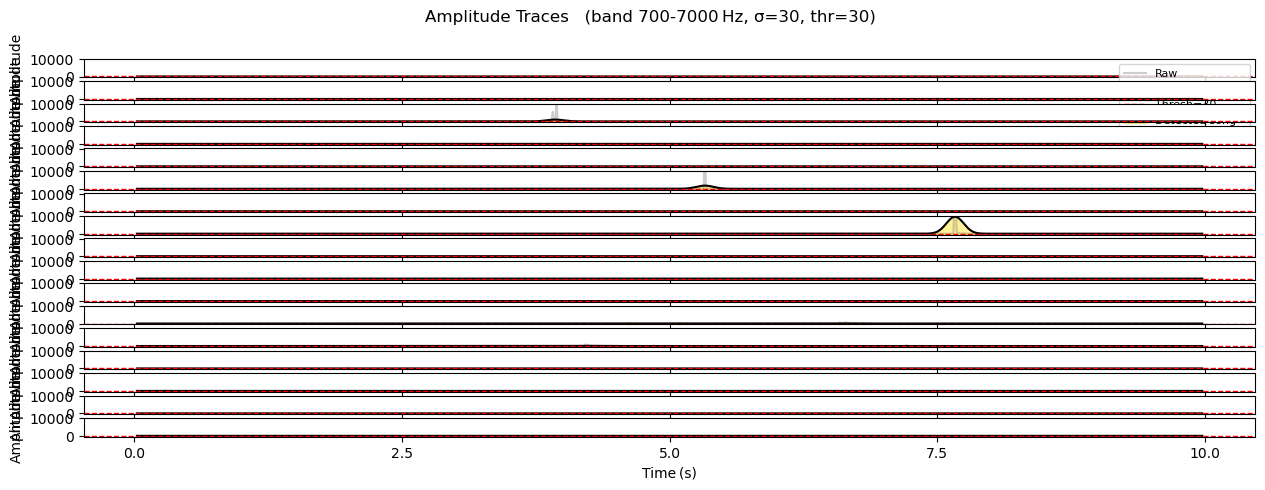

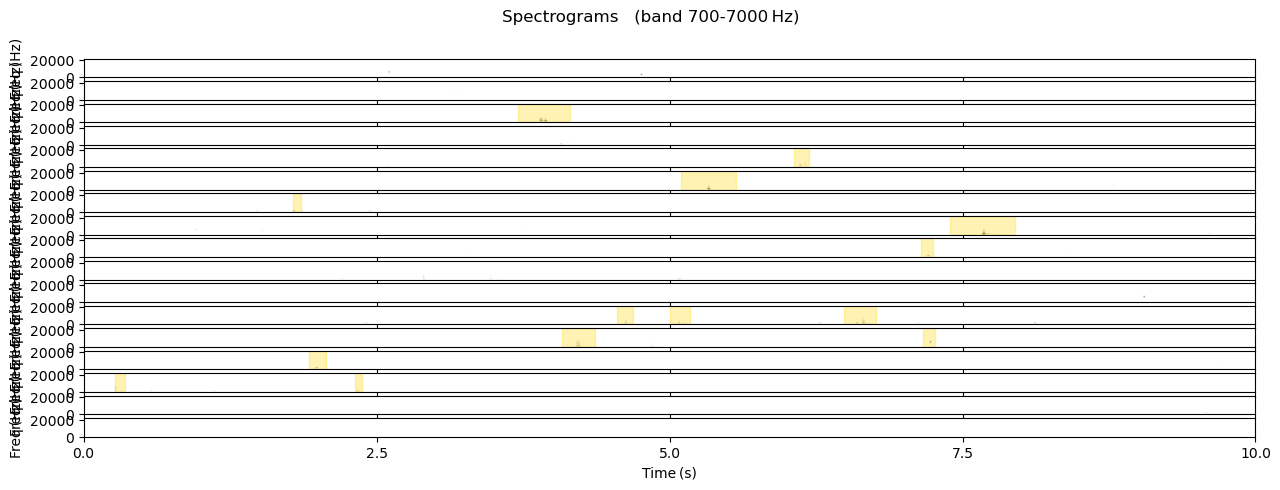

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path

# ------------------------------------------------------------
# Utility ── get screen size in inches (≈100 dpi assumption)
# ------------------------------------------------------------
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width  = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100   # inches

width_inches, height_inches = get_screen_resolution()
print(f"Screen size ≈ {width_inches:.1f} × {height_inches:.1f} inches")

# ------------------------------------------------------------
# Main visualisation routine
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05
    ):
    """
    Plot stacked amplitude traces and spectrograms for a WAV file, forcing all
    amplitude panels to share identical y‑axis limits.

    Parameters
    ----------
    file_path : str
        Path to the WAV file.
    segment_duration : float, default 10
        Seconds per panel (six panels = 1 min total).
    bandpass_filter_low_cut : float
        Lower edge of band‑pass filter (Hz).
    bandpass_filter_high_cut : float
        Upper edge of band‑pass filter (Hz).
    sigma : float, default 100
        σ (samples) for Gaussian smoothing of the amplitude trace.
    threshold : float, default 0.05
        Decision boundary applied to the smoothed trace.
    """
    try:
        # ---------- 1. Load audio ----------
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:                      # stereo → mono
            data = data.mean(axis=1)

        # ---------- 2. Band‑pass filter ----------
        nyquist = samplerate / 2
        wp      = [bandpass_filter_low_cut / nyquist,
                   bandpass_filter_high_cut / nyquist]
        b, a    = ellip(5, 0.2, 40, wp, btype='band')
        data    = filtfilt(b, a, data)

        # ---------- 3. Segment bookkeeping ----------
        segment_len  = int(segment_duration * samplerate)
        num_segments = int(np.ceil(len(data) / segment_len))

        # ---------- 4. Prepare figure stacks ----------
        fig1, axs_amp  = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        fig2, axs_spec = plt.subplots(num_segments, 1,
                                      figsize=(width_inches,
                                               height_inches * 0.5),
                                      sharex=True)
        if num_segments == 1:      # keep iterable
            axs_amp  = [axs_amp]
            axs_spec = [axs_spec]

        # ---------- 5. Loop through segments ----------
        global_amp_min, global_amp_max = np.inf, -np.inf

        for i in range(num_segments):
            start = i * segment_len
            end   = start + segment_len
            seg   = np.zeros(segment_len, dtype=data.dtype)
            seg[:max(0, min(segment_len, len(data) - start))] = data[start:end]

            # ----- Spectrogram -----
            f, t, Sxx = spectrogram(
                seg,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )
            Sxx_log  = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log  = np.clip(Sxx_log, -2, None)
            Sxx_norm = ((Sxx_log - Sxx_log.min()) /
                        (Sxx_log.max() - Sxx_log.min()))

            # ----- Amplitude trace -----
            band_rows   = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
            amp_trace   = np.sum(Sxx[band_rows, :], axis=0)
            smooth_trace = gaussian_filter1d(amp_trace, sigma=sigma)
            is_song      = smooth_trace > threshold

            # Track global min/max for unified y‑axis
            global_amp_min = min(global_amp_min, smooth_trace.min())
            global_amp_max = max(global_amp_max, smooth_trace.max())

            # ----- Plot amplitude panel -----
            ax1 = axs_amp[i]
            ax1.plot(t, amp_trace,    color='gray',  alpha=0.4, label='Raw')
            ax1.plot(t, smooth_trace, color='black',           label=f'Smoothed σ={sigma}')
            ax1.axhline(threshold, color='red', linestyle='--', linewidth=1,
                        label=f'Thresh={threshold}')
            ax1.fill_between(t, smooth_trace, threshold, where=is_song,
                             color='gold', alpha=0.4,
                             label='Detected song' if i == 0 else None)
            ax1.set_ylabel('Amplitude')
            if i == 0:
                ax1.legend(fontsize=8, loc='upper right')
            if i == num_segments - 1:
                ax1.set_xlabel('Time (s)')
                ax1.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax1.set_xticks([])

            # ----- Plot spectrogram panel -----
            ax2 = axs_spec[i]
            ax2.imshow(Sxx_norm, aspect='auto', origin='lower',
                       extent=[0, segment_duration, f.min(), f.max()],
                       cmap='binary')
            ax2.fill_between(t, f.min(), f.max(), where=is_song,
                             color='gold', alpha=0.3)
            ax2.set_ylabel('Freq (Hz)')
            if i == num_segments - 1:
                ax2.set_xlabel('Time (s)')
                ax2.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax2.set_xticks([])

            # Console feedback
            status = "🎵 Song detected" if np.any(is_song) else "⚪ No song"
            print(f"Segment {i+1}: {status}")

        # ---------- 6. Apply common y‑limits ----------
        pad = 0.05 * (global_amp_max - global_amp_min or 1)
        common_ylim = (global_amp_min - pad, global_amp_max + pad)
        for ax in axs_amp:
            ax.set_ylim(common_ylim)

        # ---------- 7. Titles & layout ----------
        bp_range = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
        fig1.suptitle(f'Amplitude Traces   (band {bp_range}, σ={sigma}, thr={threshold})',
                      fontsize=12)
        fig2.suptitle(f'Spectrograms   (band {bp_range})', fontsize=12)
        plt.tight_layout()
        plt.show()

    except ValueError as err:
        print(f"[ERROR] {file_path}: {err}")

# ------------------------------------------------------------
# Example call – replace with your own WAV
# ------------------------------------------------------------
if __name__ == "__main__":
    example_wav = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files/USA5510_45755.26270678_4_8_7_17_50.wav")  # ⇦ change me!
    if example_wav.exists():
        plot_spectrograms_by_segment(
            file_path=str(example_wav),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=30,
            threshold=30
        )
    else:
        print(f"Example WAV not found: {example_wav}")


# Amplitude only pipeline: Appy this to a folder of .wav files, then output a .json file with every .wav file name and the time segments of detected songs

## Change the folder_path in line 125 to the folder of .wav files you'd like to detect songs on.

In [16]:
#!/usr/bin/env python
"""
Batch song‑interval detector
---------------------------
Run this on a directory full of .wav files and it will create
<folder_name>_amplitude_only_detected_song_intervals.json
next to that directory.

JSON structure (per file):
{
    "example.wav": [
        [start_s0, end_s0],
        [start_s1, end_s1],
        ...
    ],
    ...
}
"""
import json
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict, Union

from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d


# ------------------------------------------------------------------
# Core detection routine  ― returns a list of (start, end) intervals
# ------------------------------------------------------------------
def detect_song_intervals(
    file_path: Union[str, Path],
    *,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma: float = 100,
    threshold: float = 0.05,
) -> List[Tuple[float, float]]:
    """Detect song intervals in `file_path` and return a list of (start, end) seconds."""
    file_path = Path(file_path)
    samplerate, data = wavfile.read(file_path)
    if data.ndim > 1:  # stereo → mono
        data = data.mean(axis=1)

    # ---- band‑pass filter ----
    nyquist = samplerate / 2
    wp = [bandpass_filter_low_cut / nyquist,
          bandpass_filter_high_cut / nyquist]
    b, a = ellip(5, 0.2, 40, wp, btype="band")
    data = filtfilt(b, a, data)

    # ---- spectrogram (same params as in your plotting code) ----
    nperseg = 2048
    noverlap = nperseg - 119
    f, t, Sxx = spectrogram(
        data,
        fs=samplerate,
        window=windows.gaussian(nperseg, std=nperseg / 8),
        nperseg=nperseg,
        noverlap=noverlap,
    )

    # ---- amplitude envelope inside the pass‑band ----
    band_rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
    amp_trace = np.sum(Sxx[band_rows, :], axis=0)
    smooth_trace = gaussian_filter1d(amp_trace, sigma=sigma)
    is_song = smooth_trace > threshold

    # ---- convert the Boolean mask into contiguous intervals ----
    if not np.any(is_song):
        return []

    # time resolution of one spectrogram column
    frame_dur = (t[1] - t[0]) if len(t) > 1 else 0
    # pad 0 at both ends so diff finds edges cleanly
    padded = np.pad(is_song.astype(int), (1, 1))
    changes = np.diff(padded)
    starts = np.where(changes == 1)[0]         # rising edges
    ends   = np.where(changes == -1)[0]        # falling edges

    intervals: List[Tuple[float, float]] = []
    for s_idx, e_idx in zip(starts, ends):
        start_s = t[s_idx]
        end_s   = t[e_idx - 1] + frame_dur     # include last frame width
        intervals.append((float(start_s), float(end_s)))

    return intervals


# ------------------------------------------------------------------
# Batch driver
# ------------------------------------------------------------------
def process_folder(
    folder_path: Union[str, Path],
    *,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma: float = 100,
    threshold: float = 0.05,
    overwrite: bool = True,
) -> Path:
    folder_path = Path(folder_path).expanduser().resolve()
    assert folder_path.is_dir(), f"{folder_path} is not a directory"

    # output JSON name mirrors the folder name
    json_path = folder_path.with_suffix("")  # drop any trailing '/'
    json_path = json_path.parent / f"{json_path.name}_amplitude_only_detected_song_intervals.json"

    if json_path.exists() and not overwrite:
        raise FileExistsError(f"{json_path} already exists (use overwrite=True to replace)")

    results: Dict[str, List[List[float]]] = {}

    wav_files = sorted(folder_path.glob("*.wav"))
    print(f"📂 Processing {len(wav_files)} .wav files in: {folder_path}")

    for wav_file in wav_files:
        intervals = detect_song_intervals(
            wav_file,
            bandpass_filter_low_cut=bandpass_filter_low_cut,
            bandpass_filter_high_cut=bandpass_filter_high_cut,
            sigma=sigma,
            threshold=threshold,
        )
        # summary line (music note if >0 segments else hollow circle)
        icon = "🎵" if intervals else "⚪"
        print(f"{icon} {wav_file.name:<45} {len(intervals)} segment{'s' if len(intervals)!=1 else ''}")

        # convert tuples → lists so JSON is valid
        results[wav_file.name] = [list(iv) for iv in intervals]

    with open(json_path, "w") as f:
        json.dump(results, f, indent=4)

    print(f"\n✅ Saved results to {json_path}")
    return json_path


# ------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------
if __name__ == "__main__":
    # EDIT THIS to point at your directory of WAVs
    folder = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files"

    # Optional: tweak parameters here
    process_folder(
        folder,
        bandpass_filter_low_cut=700,
        bandpass_filter_high_cut=7000,
        sigma=30,
        threshold=30,
    )


📂 Processing 5 .wav files in: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files
🎵 USA5510_45755.26006037_4_8_7_13_26.wav        6 segments
🎵 USA5510_45755.26030477_4_8_7_13_50.wav        2 segments
🎵 USA5510_45755.26071817_4_8_7_14_31.wav        3 segments
🎵 USA5510_45755.26110762_4_8_7_15_10.wav        14 segments
🎵 USA5510_45755.26270678_4_8_7_17_50.wav        3 segments

✅ Saved results to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files_amplitude_only_detected_song_intervals.json


## Optional: This code uses the previously-generated amplitude_only_detected_song_intervals, and checks for any time segments of detected song that fall 1 second or less apart from each other - if they are, then it comebines them into one detected time segment.

In [15]:
import json
from pathlib import Path

# ------------------------------------------------------------
# CONFIG – detector JSON and merge gap
# ------------------------------------------------------------
#json_path = Path(
#    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
#    "data_inputs/USA5510_unsegmented_songs/55_amplitude_only_detected_song_intervals.json"
#).expanduser().resolve()
json_path = out_path
merge_gap = 2.0          # seconds between intervals to weld

assert json_path.is_file(), f"Cannot find {json_path}"
print(f"Loading intervals from: {json_path}")

# ------------------------------------------------------------
# Helper – merge one file’s intervals
# ------------------------------------------------------------
def merge_intervals(intervals, gap=1.0):
    """Merge adjacent intervals whose silence ≤ gap seconds."""
    if not intervals:
        return []

    merged = []
    cur_start, cur_end = intervals[0]

    for start, end in intervals[1:]:
        if start - cur_end <= gap:       # extend current span
            cur_end = max(cur_end, end)
        else:                            # push & start new span
            merged.append([cur_start, cur_end])
            cur_start, cur_end = start, end

    merged.append([cur_start, cur_end])
    return merged

# ------------------------------------------------------------
# Load → merge → build new dict
# ------------------------------------------------------------
with open(json_path) as f:
    interval_dict = json.load(f)

combined_dict = {
    fname: merge_intervals(sorted(intervals, key=lambda x: x[0]), gap=merge_gap)
    for fname, intervals in interval_dict.items()
}

# ------------------------------------------------------------
# Pretty print summary
# ------------------------------------------------------------
print("\nSummary (after merging):\n")
for fname in sorted(combined_dict):
    seg_count = len(combined_dict[fname])
    icon = "🎵" if seg_count else "⚪"
    print(f"  {icon} {fname:<45} {seg_count:2d} segments")

# ------------------------------------------------------------
# Save combined file
# ------------------------------------------------------------
out_path = json_path.with_name("amplitude_only_combined_song_intervals.json")
with open(out_path, "w") as f:
    json.dump(combined_dict, f, indent=4)

print(f"\n✅  Combined intervals saved → {out_path}")


Loading intervals from: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/amplitude_only_combined_song_intervals.json

Summary (after merging):

  ⚪ USA5510_45755.22382904_4_8_6_13_2.wav          0 segments
  ⚪ USA5510_45755.23801765_4_8_6_36_41.wav         0 segments
  ⚪ USA5510_45755.24425276_4_8_6_47_5.wav          0 segments
  ⚪ USA5510_45755.25551217_4_8_7_5_51.wav          0 segments
  🎵 USA5510_45755.25568837_4_8_7_6_8.wav           8 segments
  🎵 USA5510_45755.25604998_4_8_7_6_44.wav          1 segments
  🎵 USA5510_45755.25619988_4_8_7_6_59.wav          1 segments
  🎵 USA5510_45755.25666577_4_8_7_7_46.wav          2 segments
  🎵 USA5510_45755.25701628_4_8_7_8_21.wav          2 segments
  🎵 USA5510_45755.25756457_4_8_7_9_16.wav          2 segments
  🎵 USA5510_45755.25771625_4_8_7_9_31.wav          1 segments
  🎵 USA5510_45755.25778467_4_8_7_9_38.wav          1 segments
  🎵 USA5510_45755.25804229_4_8_7_10_4.wav          3 segmen